## R magic

In [ ]:
%load_ext rpy2.ipython

## Imports

In [ ]:
import json
import pandas as pd
import numpy as np
import random
from itertools import product
import sklearn
import math
import re
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri

## Loading events from 9 EE datasets

In [ ]:
file_names = ['cg_train_graphs.json', 'epi_train_graphs.json', 'ge11_graphs.json', 'ge13_graphs.json', 'gro13_graphs.json', 'id11_graphs.json', 'mlee_graphs.json', 'pc_graphs.json','st09_graphs.json']

In [ ]:
graphs = []

In [ ]:
DIR = './'
DIR = "datasets_json/"
for fn in file_names:
  with open(DIR + fn) as ff:
    temp = [g for g in json.load(ff)]
    graphs.extend(temp)

## DataFrame construction and preview

Number of events for each dataset:
*   **cg** 4285
*   **epi** 1387
*   **ge11** 6465
*   **ge13** 1420
*   **gro13** 1543
*   **id11** 1303
*   **mlee** 3150
*   **pc** 2761
*   **st09** 4947

Total: **27261**

In [ ]:
df = pd.DataFrame(graphs)

In [ ]:
df.head()

,directed,multigraph,graph,nodes,links
0,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Pathological_formation', 'name': 'i...","[{'key': 'Theme', 'event_id': 'E3', 'source': ..."
1,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Gene_or_gene_product', 'name': 'IKK...","[{'key': 'Theme', 'event_id': 'E5', 'source': ..."
2,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Positive_regulation', 'name': 'init...","[{'key': 'Theme', 'event_id': 'E6', 'source': ..."
3,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Cancer', 'name': 'lung cancer', 'em...","[{'key': 'Theme', 'event_id': 'E8', 'source': ..."
4,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Cancer', 'name': 'tumor', 'embeddin...","[{'key': 'Theme', 'event_id': 'E9', 'source': ..."


In [ ]:
# We add the dataset name as a dataframe columns
# First tuple item = index
# Second tuple item = graph information, including the dataset name
datasets = [g[1]['dataset'] for g in df['graph'].items()]
df['dataset'] = datasets

In [ ]:
df.head()

,directed,multigraph,graph,nodes,links,dataset
0,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Pathological_formation', 'name': 'i...","[{'key': 'Theme', 'event_id': 'E3', 'source': ...",cg
1,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Gene_or_gene_product', 'name': 'IKK...","[{'key': 'Theme', 'event_id': 'E5', 'source': ...",cg
2,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Positive_regulation', 'name': 'init...","[{'key': 'Theme', 'event_id': 'E6', 'source': ...",cg
3,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Cancer', 'name': 'lung cancer', 'em...","[{'key': 'Theme', 'event_id': 'E8', 'source': ...",cg
4,True,False,"{'source_doc': 'PMID-20129250', 'dataset': 'cg...","[{'type': 'Cancer', 'name': 'tumor', 'embeddin...","[{'key': 'Theme', 'event_id': 'E9', 'source': ...",cg


## Event type retrieval

Note: in the case of nested events, we consider the trigger type of the main event (DAG root)

In [ ]:
# Obtain the root node of each graph
roots = [g[1]['root'] for g in df['graph'].items()]

In [ ]:
# Obtain a list with the information of each node in each graph
nodes_list = [n[1] for n in df['nodes'].items()]

In [ ]:
# For each event graph, we take the type information from the trigger node (id matching)
event_type = [n['type'] for i in range(len(graphs)) for n in nodes_list[i] if n['id'] == roots[i]] 

### Gro13 corrections

**gro13** dataset has event types written in *CamelCase* instead of *snake_case*. Arguably, we perform a conversion preprocessing step to lowercase.

In [ ]:
event_type = [re.sub(r'(?<!^)(?=[A-Z])', '_', event_type[i]).lower() if datasets[i]=='gro13' else event_type[i].lower() for i in range(len(graphs))]

In [ ]:
df['event_type'] = event_type

In [ ]:
df['event_type'].value_counts()

positive_regulation            8090
negative_regulation            4106
regulation                     3566
gene_expression                2830
binding                        1969
                               ... 
intra_cellular_transport          1
stabilization                     1
binding_of_protein                1
binding_of_molecular_entity       1
regulation_of_function            1
Name: event_type, Length: 122, dtype: int64

In [ ]:
sum(df['dataset'] == 'gro13')

1543

## \#Node distribution

Number of event graph instances for each graph size class (i.e., number of nodes).

In [ ]:
lenghts = [len(nodes_list[i]) for i in range(len(df))]

In [ ]:
df['len'] = lenghts

In [ ]:
df['len'].value_counts()

2     9927
3     8159
4     4557
5     2286
6     1163
7      597
8      258
9      170
10      68
11      39
13      17
12       8
14       6
15       3
18       2
16       1
Name: len, dtype: int64

### Introducing a range for event graph size

Starting from the event graph distribution for each graph size, a reasonable splitting on #nodes is 2, 3, 4, 5, 6, > 7.

In [ ]:
df['range_len'] = df['len'].copy()

In [ ]:
df['range_len'][df['len'] >= 7] = 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['range_len'] = [str(n) for n in df['range_len']]

In [ ]:
df['range_len'].value_counts()

2    9927
3    8159
4    4557
5    2286
7    1169
6    1163
Name: range_len, dtype: int64

## \#Instance-based event type filtering

With the introduction of **gro13**, the number of event types grows from 50 to 100. However, some of such event types have less than 10 instances. By removing these poorly represented event types, the total number of classes returns to about 50.

In [ ]:
df = df.groupby('event_type').filter(lambda x : len(x) > 10)
df['event_type'].value_counts(), len(df['event_type'].value_counts())

(positive_regulation                       8090
 negative_regulation                       4106
 regulation                                3566
 gene_expression                           2830
 binding                                   1969
 planned_process                            959
 localization                               686
 transcription                              427
 phosphorylation                            424
 process                                    305
 development                                252
 glycosylation                              233
 methylation                                230
 acetylation                                228
 dna_methylation                            226
 regulatory_process                         210
 ubiquitination                             182
 pathway                                    147
 catalysis                                  138
 binding_to_protein                         135
 activation                             

## Stratified sampling with R

We remove unnecessary columns to speed-up the following operations.

In [ ]:
data = df.copy()

In [ ]:
data.drop(columns=['graph', 'nodes', 'len', 'links'], inplace=True)

In [ ]:
data.head()

,directed,multigraph,dataset,event_type,range_len
0,True,False,cg,positive_regulation,5
1,True,False,cg,positive_regulation,4
2,True,False,cg,positive_regulation,3
3,True,False,cg,development,2
4,True,False,cg,positive_regulation,2


In [ ]:
grouped_events = data.groupby(['dataset', 'event_type', 'range_len']).count()
grouped_events

directed  multigraph
dataset event_type    range_len                      
cg      acetylation   2                 2           2
        binding       2                26          26
                      3                37          37
                      4                18          18
                      5                 3           3
...                                   ...         ...
st09    regulation    6                39          39
                      7                22          22
        transcription 2               100         100
                      3                17          17
                      4                 8           8

[545 rows x 2 columns]

keep only event graphs whitin a class (i.e., dataset, event type, graph size) having at least 3 instances

In [ ]:
data = data.groupby(['dataset', 'event_type', 'range_len']).filter(lambda x : len(x) >= 10)

We install and load the "stratify" package.

In [ ]:
%%R
install.packages("splitstackshape")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/splitstackshape_1.4.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 33972 bytes (33 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [ ]:
%%R
library(splitstackshape)

In [ ]:
# - Grouping on dataset name, event type, and graph size range
%%R -i data
samples <- stratified(data, c('dataset', 'event_type', 'range_len'), 4, replace=FALSE, keep.rownames=TRUE)
print(nrow(samples))

[1] 1216


In [ ]:
s = %R samples

## Sampling post-processing and visualizations

In [ ]:
print(s)
# Note: 'rn' is the event graph id (i.e., row number on the dataset before sampling)

         rn  directed  multigraph dataset           event_type range_len
1      1050         1           0      cg  positive_regulation         5
2      1038         1           0      cg  positive_regulation         5
3      4059         1           0      cg  positive_regulation         5
4      2382         1           0      cg  positive_regulation         5
5       707         1           0      cg  positive_regulation         4
...     ...       ...         ...     ...                  ...       ...
1212  24960         1           0    st09        transcription         3
1213  24250         1           0    st09  negative_regulation         5
1214  25502         1           0    st09  negative_regulation         5
1215  25395         1           0    st09  negative_regulation         5
1216  24835         1           0    st09  negative_regulation         5

[1216 rows x 6 columns]


In [ ]:
s['rn'] = [int(n) for n in s['rn']]

In [ ]:
final = df.loc[list(s['rn']), :]

In [ ]:
final['event_type'].value_counts()

positive_regulation                       180
negative_regulation                       172
regulation                                160
binding                                    92
gene_expression                            84
localization                               72
phosphorylation                            52
transcription                              36
planned_process                            24
pathway                                    20
methylation                                16
mutation                                   16
regulatory_process                         16
catalysis                                  16
binding_to_protein                         12
transport                                  12
acetylation                                12
dna_methylation                            12
glycosylation                              12
ubiquitination                             12
activation                                 12
protein_catabolism                

In [ ]:
grouped_events = final.groupby(['dataset', 'event_type', 'range_len']).count()
grouped_events

directed  multigraph  ...  links  len
dataset event_type               range_len                        ...            
cg      binding                  2                 4           4  ...      4    4
                                 3                 4           4  ...      4    4
                                 4                 4           4  ...      4    4
        blood_vessel_development 2                 4           4  ...      4    4
        breakdown                2                 4           4  ...      4    4
...                                              ...         ...  ...    ...  ...
st09    regulation               5                 4           4  ...      4    4
                                 6                 4           4  ...      4    4
                                 7                 4           4  ...      4    4
        transcription            2                 4           4  ...      4    4
                                 3                 4           4  ...      4    4

[304 rows x 6 columns]

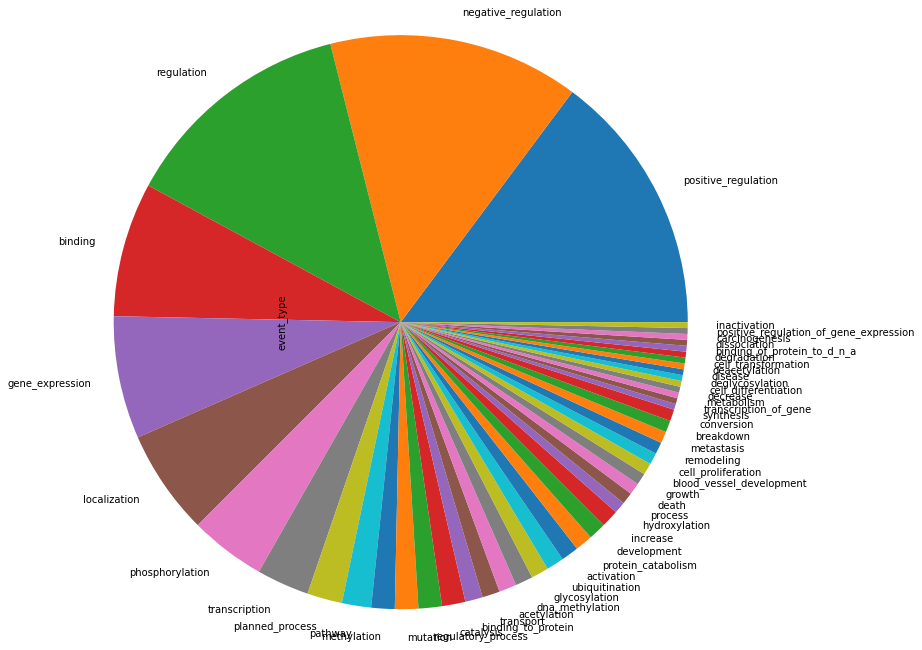

In [ ]:
final['event_type'].value_counts().plot.pie(radius=3.3)

## Writing sampled event graphs on a file

In [ ]:
r = final.copy()
r = r.drop(columns=['event_type', 'dataset', 'len', 'range_len'])
r = r.to_dict(orient='records')
with open(DIR + 'stratified_1000_all.json', 'w') as outfile:
    json.dump(r, outfile)